<div class="theme"> <h2> Explore Convolutional Neural Networks (CNNs) using CIFAR-1O dataset</h2></div> 
<br>
Exploration of the mechanics of convolutional operations using CNN model to classify CIFAR-10 images.

In [1]:
# import libraries and packages
import requests
from IPython.core.display import HTML
styles = requests.get("https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css").text
HTML(styles)

import numpy as np
import pandas as pd
from pandas import DataFrame, read_csv

from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
from keras.constraints import maxnorm
from keras.optimizers import SGD
from keras import backend as K 
K.set_image_dim_ordering('tf')

from sklearn.model_selection import cross_val_score, KFold, train_test_split, StratifiedKFold 
from sklearn.preprocessing import LabelEncoder, StandardScaler, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix

from astropy.table import Table

import glob
import h5py    

from PIL import Image
from scipy.misc import toimage
import skimage
from skimage import data, io
from skimage.transform import rescale, resize, downscale_local_mean

from matplotlib import pyplot
import matplotlib.pylab as plt 
from IPython.display import Image
%matplotlib inline

# if you do not have skimage then you may install is by running $ conda install -c anaconda scikit-image

from sklearn.metrics import classification_report
from keras.utils import to_categorical
from keras import layers
from keras import models
from keras import utils
from scipy import signal

**Detection of image edges, shape and color using pre-defined matrices**

In [4]:
dog_img_data = plt.imread('Kintamani_dog_white_gs.jpeg')
dog_img_norm = (dog_img_data/255)-0.5

R_img_norm = dog_img_norm[:,:,0]
G_img_norm = dog_img_norm[:,:,1]
B_img_norm = dog_img_norm[:,:,2]

#we notice same values for RGB as this is a grey image. so we are using only 1 channel.
R_img_relu=np.clip(R_img_norm,0,R_img_norm.max())

In [5]:
# locate edges in an image
edge_array=np.array([[-1,-1,-1],[-1,8,-1],[-1,-1,-1]])
R_edge_cnv=signal.convolve2d(R_img_relu, edge_array, boundary='symm',mode='same')

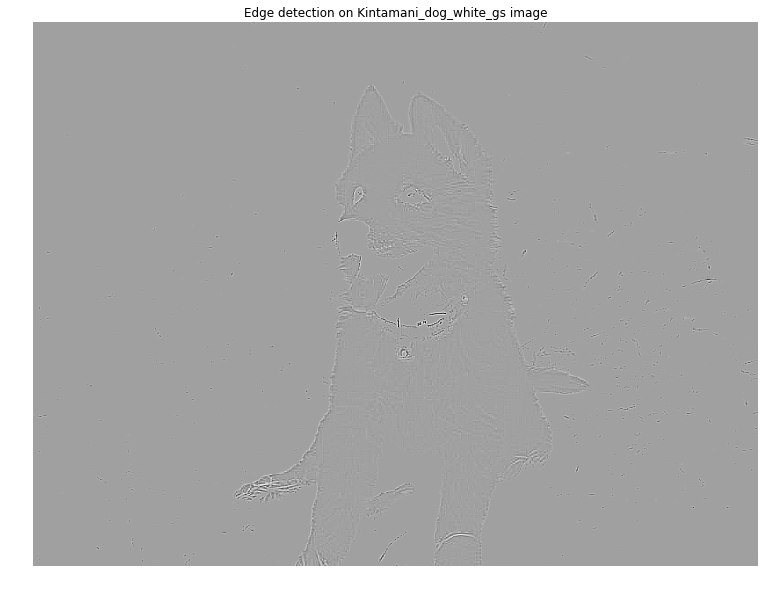

In [6]:
fig, (ax1)= plt.subplots(1,1, figsize=(20,10))

ax1.imshow(R_edge_cnv, cmap=plt.cm.gray_r)
ax1.set_title('Edge detection on Kintamani_dog_white_gs image')
ax1.set_axis_off()

In [7]:
sharp_array=np.array([[0,-1,0],[-1,5,-1],[0,-1,0]])
R_sharp_cnv=signal.convolve2d(R_img_relu, sharp_array, boundary='symm',mode='same')

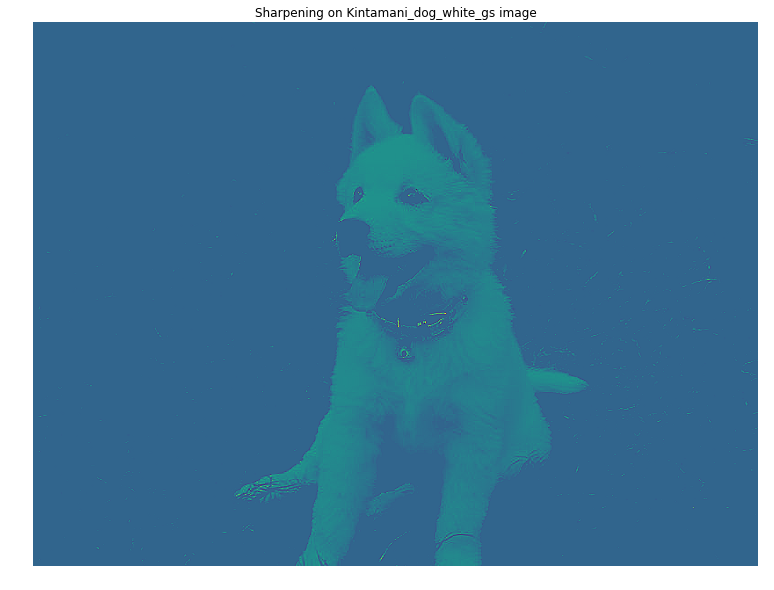

In [8]:
fig, (ax1)= plt.subplots(1,1, figsize=(20,10))

ax1.imshow(R_sharp_cnv)
ax1.set_title('Sharpening on Kintamani_dog_white_gs image')
ax1.set_axis_off()

In [9]:
blur_array = np.array(np.multiply( 1/9, [[1,1,1], [1,1,1], [1,1,1]]))
R_blur_cnv=signal.convolve2d(R_img_relu, blur_array, boundary='symm',mode='same')

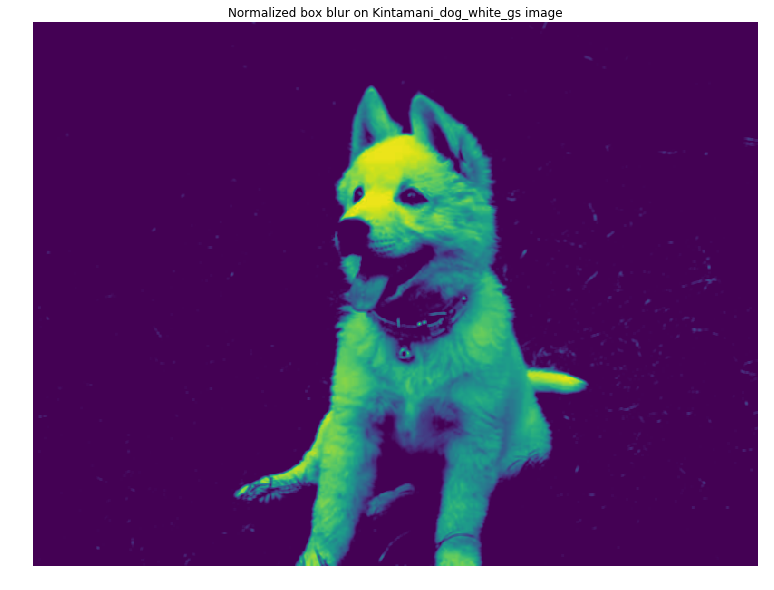

In [10]:
fig, (ax1)= plt.subplots(1,1, figsize=(20,10))

ax1.imshow(R_blur_cnv)
ax1.set_title('Normalized box blur on Kintamani_dog_white_gs image')
ax1.set_axis_off()

**Observations**<br>
In the above images, certain features in the puppy are accentuated, while others are de-emphasized. By additional convolutional layers, the network can learn translation invariant patterns, which is useful for the network to recognize the features irrespective of it's position and learn spatial hierarchies of the pattern. 
<br>
The first layer will learn small local patterns such as edges, second layer will learn larger patterns such as sharpness. This allows convnets to efficiently learn increasingly complex and abstract visual concepts.

<div class='exercise'><b> Model: Building a Basic CNN Model using CIFAR-10 image dataset</b></div>

Use Keras to create a convolutional neural network for predicting the type of object shown in images from the [CIFAR-10](https://keras.io/datasets/#cifar10-small-image-classification) dataset, which contains 50,000 32x32 training images and 10,000 test images of the same size, with a total of 10 classes.

In [11]:
from keras.datasets import cifar10
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

y_train1 = y_train.copy()  #copy original y for feature maps
y_test1 = y_test.copy() #copy original y for feature maps

x_train_std = x_train/255
x_test_std = x_test/255
y_train=to_categorical(y_train1)
y_test=to_categorical(y_test1)

In [12]:
def create_cnn_temp(filters1): 
    cnn_model = Sequential() # Create sequential model

    # Add convolution layers
    cnn_model.add(Conv2D(filters1, (3, 3), activation='relu', padding='same', input_shape=(x_train.shape[1], 
                                                                                           x_train.shape[2],
                                                                                           x_train.shape[3])))
    cnn_model.add(Conv2D(filters1, (3, 3), padding='same', activation='relu')) 
    cnn_model.add(MaxPooling2D((2, 2)))

    #Add dense layers
    cnn_model.add(Flatten())
    cnn_model.add(Dense(100, activation='relu'))
    cnn_model.add(Dropout(0.2))
    cnn_model.add(Dense(10, activation='softmax', name='lst_layer'))
    return cnn_model

cifar10_cnn=create_cnn_temp(32)

In [14]:
filter_num=[32,64,128,256,512]
params=[]

for i in filter_num:
    cifar10_cnn=create_cnn_temp(i)
    params.append(cifar10_cnn.count_params())
    
filter_param=pd.DataFrame({'Number of filters' : filter_num, 'Total number of parameters': params})    
filter_param

,Number of filters,Total number of parameters
0,32,830454
1,64,1678230
2,128,3429078
3,256,7151958
4,512,15482454


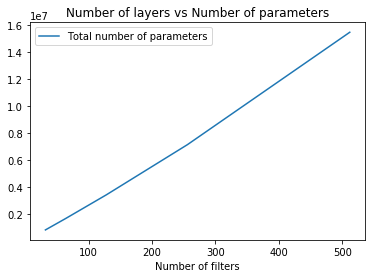

In [16]:
filter_param.plot(x='Number of filters',y='Total number of parameters', title='Number of layers vs Number of parameters');

<h3>Model Train and Evaluation</h3>

In [17]:
# plot loss vs epoch
def plot_loss_epoch(model_hist):
    fig, ax = plt.subplots(1, 1, figsize=(10,6))
    ax.plot(np.sqrt(model_hist.history['loss']), 'r', label='train')
    ax.plot(np.sqrt(model_hist.history['val_loss']), 'b' ,label='val')
    ax.set_xlabel(r'Epoch', fontsize=15)
    ax.set_ylabel(r'Loss', fontsize=15)
    ax.legend()
    ax.tick_params(labelsize=15)

In [18]:
# plot accuracy vs epoch
def plot_acc_epoch(model_hist):
    fig, ax = plt.subplots(1, 1, figsize=(10,6))
    ax.plot(np.sqrt(model_hist.history['acc']), 'r', label='train')
    ax.plot(np.sqrt(model_hist.history['val_acc']), 'b' ,label='val')
    ax.set_xlabel(r'Epoch', fontsize=15)
    ax.set_ylabel(r'Accuracy', fontsize=15)
    ax.legend()
    ax.tick_params(labelsize=15)

**Define the model**

In [19]:
#CNN for CIFAR-10 data set
# We are following the VGG16 architecture closely with small changes when mapped to our dataset

def create_cnn(filters1): 
    cnn_model = Sequential() # Create sequential model

    # Add convolution layers
    cnn_model.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(x_train.shape[1], 
                                                                                     x_train.shape[2],
                                                                                     x_train.shape[3])))
    cnn_model.add(Conv2D(32, (3, 3), padding='same', activation='relu', name='h1_layer')) 
    cnn_model.add(MaxPooling2D((2, 2)))
    cnn_model.add(Dropout(0.2))
    cnn_model.add(Conv2D(filters1*2, (3, 3), padding='same', activation='relu', name='h2_layer'))
    cnn_model.add(Conv2D(filters1*2, (3, 3), padding='same', activation='relu', name='h3_layer'))
    cnn_model.add(Conv2D(filters1*2, (3, 3), padding='same', activation='relu', name='h4_layer'))
    cnn_model.add(MaxPooling2D((2, 2)))
    cnn_model.add(Dropout(0.5))
    
    cnn_model.add(Conv2D(filters1*4, (3, 3), padding='same', activation='relu', name='h5_layer'))
    cnn_model.add(Dropout(0.2))
    
    #Add dense layers
    cnn_model.add(Flatten())
    cnn_model.add(Dense(100, activation='relu', name='d1_layer'))
    cnn_model.add(Dropout(0.2))
    cnn_model.add(Dense(10, activation='softmax', name='lst_layer'))
    
    return cnn_model

cifar10_cnn=create_cnn(32)
cifar10_cnn.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_23 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
h1_layer (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 16, 16, 32)        0         
_________________________________________________________________
dropout_12 (Dropout)         (None, 16, 16, 32)        0         
_________________________________________________________________
h2_layer (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
h3_layer (Conv2D)            (None, 16, 16, 64)        36928     
_________________________________________________________________
h4_layer (Conv2D)            (None, 16, 16, 64)        36928     
__________

**Fit the model**

In [20]:
%%time
cifar10_cnn=create_cnn(32)
cifar10_cnn.compile(optimizer="RMSprop",
              loss='categorical_crossentropy',
              metrics=['accuracy'])

cifar10_cnn_history=cifar10_cnn.fit(x_train_std, y_train, epochs=35, batch_size=128, validation_data=(x_test_std,y_test))

Train on 50000 samples, validate on 10000 samples
Epoch 1/35
50000/50000 [==============================] - 19s 389us/step - loss: 1.9045 - acc: 0.3065 - val_loss: 1.5320 - val_acc: 0.4357
Epoch 2/35
50000/50000 [==============================] - 15s 293us/step - loss: 1.4548 - acc: 0.4731 - val_loss: 1.2738 - val_acc: 0.5432
Epoch 3/35
50000/50000 [==============================] - 15s 294us/step - loss: 1.2290 - acc: 0.5645 - val_loss: 1.0478 - val_acc: 0.6259
Epoch 4/35
50000/50000 [==============================] - 15s 291us/step - loss: 1.0691 - acc: 0.6254 - val_loss: 0.9371 - val_acc: 0.6776
Epoch 5/35
50000/50000 [==============================] - 15s 292us/step - loss: 0.9646 - acc: 0.6635 - val_loss: 0.8521 - val_acc: 0.7017
Epoch 6/35
50000/50000 [==============================] - 15s 295us/step - loss: 0.8830 - acc: 0.6925 - val_loss: 0.9465 - val_acc: 0.6716
Epoch 7/35
50000/50000 [==============================] - 15s 293us/step - loss: 0.8189 - acc: 0.7130 - val_loss: 0.

In [21]:
score = cifar10_cnn.evaluate(x_train_std, y_train, verbose=0)
print('Train loss: {:.4f}'.format(score[0]))
print('Train accuracy: {:.4f}'.format(score[1]))

score = cifar10_cnn.evaluate(x_test_std, y_test, verbose=0)
print('Test loss: {:.4f}'.format(score[0]))
print('Test accuracy: {:.4f}'.format(score[1]))

Train loss: 0.6391
Train accuracy: 0.8572
Test loss: 0.7906
Test accuracy: 0.7751


**Prediction using Classification Report**

In [22]:
from sklearn.metrics import classification_report
print("Classification report for baseline classifier")
y_test_pred=cifar10_cnn.predict_classes(x_test_std)
y_test_pred = to_categorical(y_test_pred) 
# print(confusion_matrix(y_test, y_test_pred))
print(classification_report(y_test,y_test_pred))

Classification report for baseline classifier
              precision    recall  f1-score   support

           0       0.72      0.85      0.78      1000
           1       0.95      0.79      0.86      1000
           2       0.85      0.58      0.69      1000
           3       0.64      0.55      0.59      1000
           4       0.62      0.85      0.72      1000
           5       0.76      0.63      0.69      1000
           6       0.75      0.88      0.81      1000
           7       0.83      0.84      0.84      1000
           8       0.86      0.91      0.88      1000
           9       0.84      0.87      0.86      1000

   micro avg       0.78      0.78      0.78     10000
   macro avg       0.78      0.78      0.77     10000
weighted avg       0.78      0.78      0.77     10000
 samples avg       0.78      0.78      0.78     10000



**Plot of validation loss and accuracy**

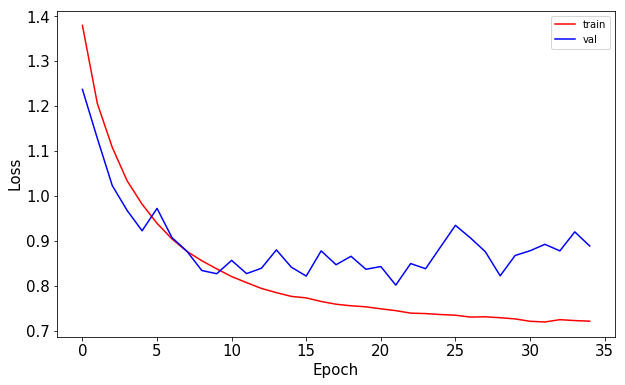

In [23]:
plot_loss_epoch(cifar10_cnn_history)

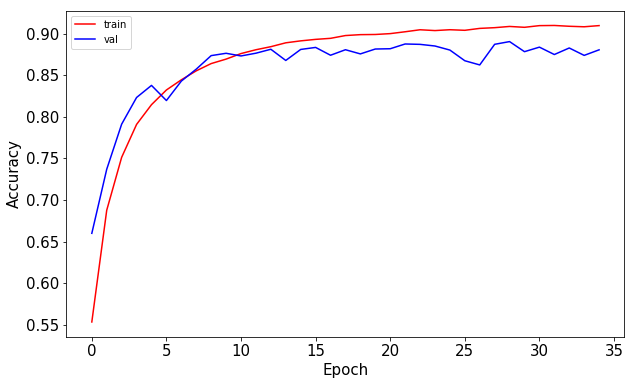

In [24]:
plot_acc_epoch(cifar10_cnn_history)

**We would gain an intution into how the model is processing the inputs in two ways, namely feature maps and saliency maps**

<span class='sub-q'>**Using Feature Maps to Visualize the Model.**</span>
<br>
Feature maps helps to visualize the activations in the intermediate layers of the network. 

In [25]:
# The function `get_feature_maps` to aid in extracting weights from layers in your model network

def get_feature_maps(model, layer_id, input_image):
    model_ = Model(inputs=[model.input], outputs=[model.layers[layer_id].output])
    return model_.predict(np.expand_dims(input_image, axis=0))[0,:,:,:].transpose((2,0,1))

*Some imports that will come in handy if you use keras-vis to implement saliency maps*

In [26]:
from vis.visualization import visualize_saliency
from vis.utils import utils
from keras import activations

In [27]:
layer_ind=utils.find_layer_idx(cifar10_cnn,'h1_layer')
print("Layer index is", layer_ind)

Layer index is 1


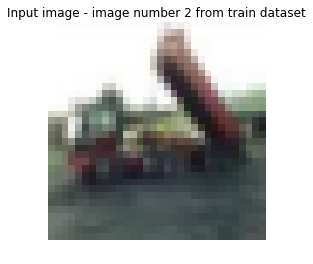

In [28]:
img_sel = 2
test_img=x_train[img_sel,:,:,:]
get_feature_maps
feature_maps=get_feature_maps(cifar10_cnn, layer_ind, test_img)  #extracting feature map from layer1
# feature_maps.shape

y_inp_img=y_train1[img_sel,:]

plt.imshow(test_img);
plt.axis('off')
plt.title('Input image - image number %d from train dataset'%(img_sel));

In [29]:
# print the predictions for the test image
#highest score is for 0th element which is equal to the variable 'y_inp_img' (which is the actual class of input image)

print("Prediction class is ", cifar10_cnn.predict_classes(np.expand_dims(test_img/255, axis=0)))

#print acutal value of class
print("Input image class is", y_inp_img)

Prediction class is  [9]
Input image class is [9]


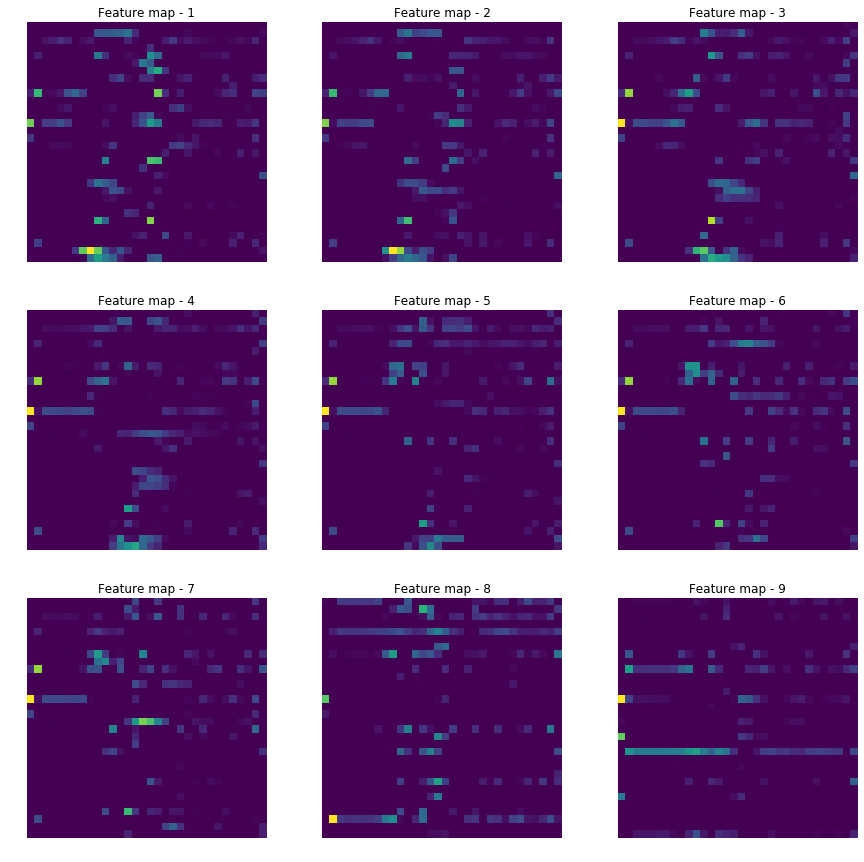

In [30]:
fig, ((ax1,ax2,ax3),(ax4,ax5,ax6),(ax7,ax8,ax9)) = plt.subplots(3,3,figsize=(15,15))
axs=[ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8,ax9]
for i,val in enumerate(range(feature_maps.shape[2]-9, feature_maps.shape[2])):  #select last 9 feature map
    feature1=feature_maps[ :, :, val]
    feature1=feature1/feature1.max()
    axs[i].imshow(feature1)
    axs[i].set_axis_off()
    axs[i].set_title('Feature map - %d'%(i+1))

**Using saliency maps**<br>
[Saliency maps](https://arxiv.org/abs/1312.6034) to visualize the pixels that have the largest impact on the classification of an input (image in this case).

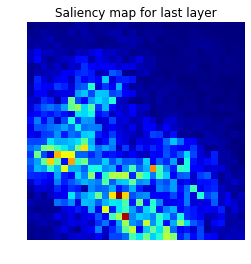

In [32]:
layer_ind=utils.find_layer_idx(cifar10_cnn,'lst_layer')

# switch off the softmax activation
cifar10_cnn.layers[layer_ind].activation = activations.linear
cifar10_cnn = utils.apply_modifications(cifar10_cnn)

grads = visualize_saliency(cifar10_cnn, layer_ind, filter_indices=y_inp_img,  seed_input=test_img)
plt.imshow(grads, cmap='jet');
plt.axis('off')
plt.title('Saliency map for last layer');